**Data Generation with  Missing Values**

This code generates a synthetic dataset simulating environmental emissions and temperature data for 500 samples. It creates normally distributed values for CO2, Methane, NOx, and Temperature. Then, it randomly inserts 10% missing values throughout the dataset to mimic incomplete data.

In [39]:
import numpy as np
import pandas as pd

np.random.seed(42)

n_samples = 500

co2 = np.random.normal(50, 10, n_samples)
methane = np.random.normal(25, 5, n_samples)
nox = np.random.normal(18, 3, n_samples)
temperature = np.random.normal(20, 2, n_samples)

data = pd.DataFrame({
    'CO2': co2,
    'Methane': methane,
    'NOx': nox,
    'Temperature': temperature
})

total_values = data.size
n_missing = int(total_values * 0.10)
missing_indices = np.random.choice(total_values, n_missing, replace=False)

flat_data = data.values.flatten()
flat_data[missing_indices] = np.nan

data_missing = pd.DataFrame(flat_data.reshape(data.shape), columns=data.columns)

data_missing.to_csv('emission_missing_data.csv', index=False)

print("File 'emission_missing_data.csv' created with 10% missing values.")
print(data_missing.head(10))


File 'emission_missing_data.csv' created with 10% missing values.
         CO2    Methane        NOx  Temperature
0  54.967142  29.630888  22.198066          NaN
1  48.617357  34.547083  20.773901    18.897629
2        NaN  18.007162  18.178891    18.363602
3  65.230299  27.814846  16.059190          NaN
4  47.658466  21.746787  20.094670    19.659631
5  47.658630  22.564373  19.180456          NaN
6  65.792128  22.038030  20.685580    21.392775
7  57.674347        NaN  19.905515    21.910610
8  45.305256        NaN        NaN    20.176814
9  55.425600  20.845249  16.394294    22.955060


**Advanced Missing Data Imputation Using IterativeImputer with KNN Estimator**

This code loads the dataset containing missing values  and performs advanced imputation to fill those missing entries. It uses IterativeImputer from scikit-learn with a K-Nearest Neighbors (KNN) regressor as the estimator, iteratively predicting and imputing missing values based on neighboring data points.

In [41]:
import pandas as pd
import numpy as np
import warnings
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.exceptions import ConvergenceWarning
import matplotlib.pyplot as plt

warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

data_missing = pd.read_csv('emission_missing_data.csv')

knn_estimator = KNeighborsRegressor(n_neighbors=5)
iterative_imputer = IterativeImputer(
    estimator=knn_estimator, 
    max_iter=10, 
    random_state=42
)

data_imputed = pd.DataFrame(
    iterative_imputer.fit_transform(data_missing),
    columns=data_missing.columns
)

print("Data after advanced imputation with KNN in IterativeImputer:")
print(data_imputed.head())
data_imputed.to_csv('challenge2.csv', index=False)
print("Complete imputed dataset saved as 'challenge2.csv'.")


Data after advanced imputation with KNN in IterativeImputer:
         CO2    Methane        NOx  Temperature
0  54.967142  29.630888  22.198066    17.416456
1  48.617357  34.547083  20.773901    18.897629
2  49.508730  18.007162  18.178891    18.363602
3  65.230299  27.814846  16.059190    22.357310
4  47.658466  21.746787  20.094670    19.659631
Complete imputed dataset saved as 'challenge2.csv'.


**Synthetic Data Generation Using a GAN-Based Generator Network**

This code defines a Generative Adversarial Network (GAN) architecture in PyTorch, focusing on the Generator to create synthetic environmental emission data. It loads the original and imputed datasets, then builds a generator neural network that transforms random noise vectors into synthetic data samples matching the dimensions of the original dataset. The synthetic outputs are rescaled to the original data ranges and saved as challenge2_gan_generated.csv.

In [29]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

data = pd.read_csv('emission_missing_data.csv')
data_imputed = pd.read_csv('challenge2.csv')

class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(128),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(256),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(512),
            nn.Linear(512, output_dim),
            nn.Tanh()
        )
    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

latent_dim = 100
output_dim = data_imputed.shape[1]
generator = Generator(latent_dim, output_dim)

z = torch.randn(500, latent_dim)
synthetic_data = generator(z).detach().numpy()

def rescale(col_data, original_col):
    min_val = original_col.min()
    max_val = original_col.max()
    return 0.5 * (col_data + 1) * (max_val - min_val) + min_val

synthetic_rescaled = np.zeros_like(synthetic_data)
for i, col in enumerate(data_imputed.columns):
    synthetic_rescaled[:, i] = rescale(synthetic_data[:, i], data_imputed[col])

synthetic_df = pd.DataFrame(synthetic_rescaled, columns=data_imputed.columns)
synthetic_df.to_csv('challenge2_gan_generated.csv', index=False)


**Visualization of Data Distributions Before and After Imputation**

This code defines a function to visualize the effect of imputation on each feature in the dataset. For every column, it plots two side-by-side histograms: one showing the distribution of data before imputation, and the other showing the distribution after missing values have been filled. This allows for a visual comparison to assess how well the imputation method preserved or altered the original data distribution. 

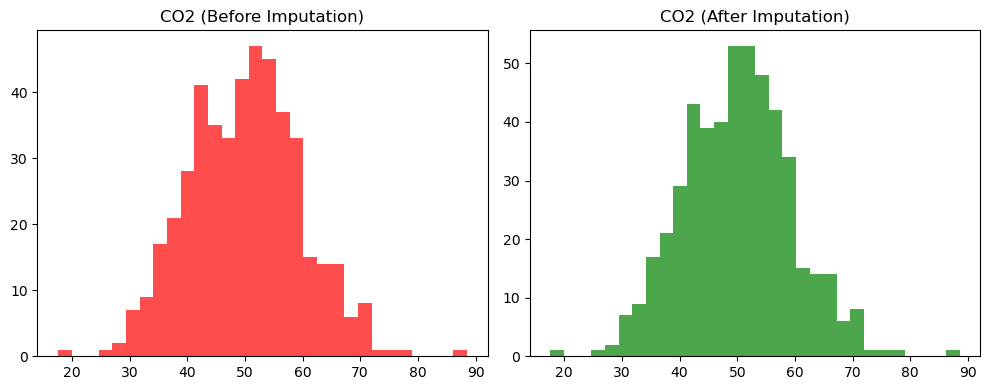

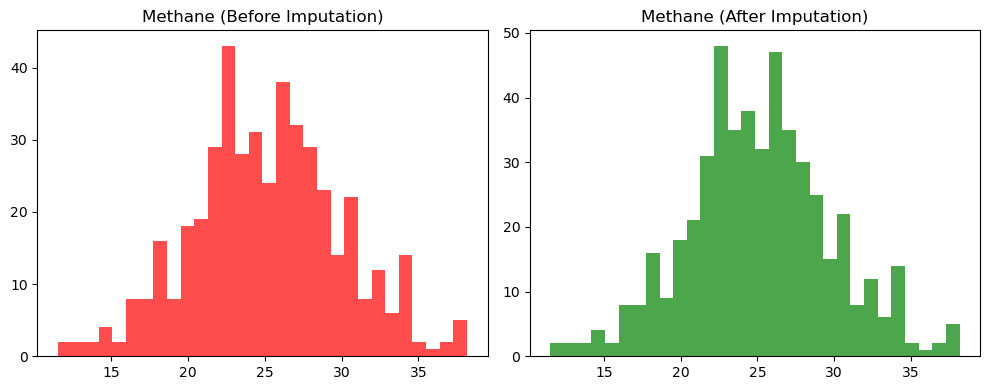

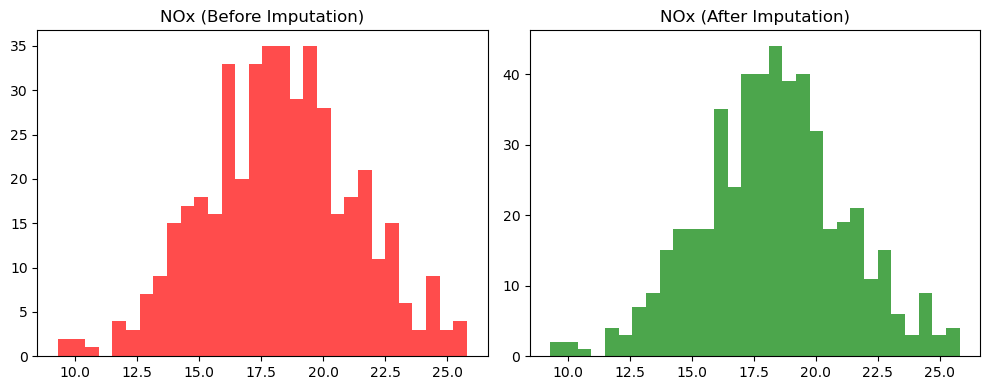

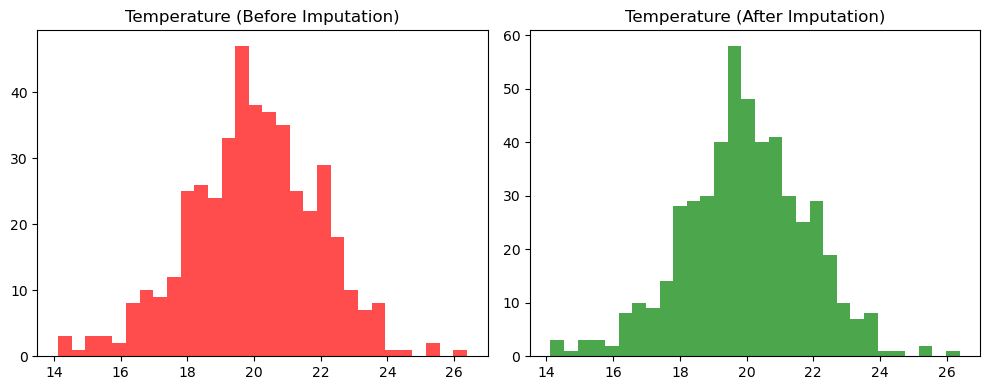

In [31]:
import matplotlib.pyplot as plt

def plot_imputation_effect(missing_data, imputed_data, column):
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.hist(missing_data[column].dropna(), bins=30, color='red', alpha=0.7)
    plt.title(f'{column} (Before Imputation)')
    
    plt.subplot(1, 2, 2)
    plt.hist(imputed_data[column], bins=30, color='green', alpha=0.7)
    plt.title(f'{column} (After Imputation)')
    
    plt.tight_layout()
    plt.show()

for col in data_missing.columns:
    plot_imputation_effect(data_missing, data_imputed, col)


The imputation preserved the original data distributions, as shown by the similar shapes of the histograms before and after imputation. This consistency indicates that the imputation method successfully filled missing values.

**Comparison of Basic Statistics Before and After Imputation**

This code prints the summary statistics of the dataset both before and after imputation. By comparing measures such as mean, standard deviation, minimum, and maximum values, it helps to verify whether the imputation process maintained the overall statistical characteristics of the data. 

In [37]:
print("\n--- Basic Statistics Before Imputation ---")
print(data_missing.describe())

print("\n--- Basic Statistics After Imputation ---")
print(data_imputed.describe())



--- Basic Statistics Before Imputation (available values only) ---
              CO2     Methane         NOx  Temperature
count  460.000000  452.000000  448.000000   440.000000
mean    50.026305   25.162152   18.261853    19.991469
std      9.671907    4.878740    3.042516     1.934699
min     17.587327   11.515567    9.311234    14.119223
25%     42.839112   22.096163   16.167936    18.716003
50%     50.462762   25.132442   18.210720    19.959213
75%     56.307014   28.245414   20.186647    21.319521
max     88.527315   38.161910   25.805049    26.386215

--- Basic Statistics After Imputation ---
              CO2     Methane         NOx  Temperature
count  500.000000  500.000000  500.000000   500.000000
mean    50.014633   25.117869   18.262996    19.970952
std      9.357992    4.687925    2.913139     1.853962
min     17.587327   11.515567    9.311234    14.119223
25%     43.234928   22.200960   16.300168    18.757404
50%     50.227570   25.046140   18.284410    19.949399
75%     5

 The means, standard deviations, and quartiles before and after imputation are very close, showing the data’s distribution was well preserved.

**correlation Matrix Comparison Before and After Imputation**

This code visualizes the correlation matrices of the dataset before and after imputation using heatmaps. The heatmaps allow us to compare how the relationships between variables (like CO2, Methane, NOx, and Temperature) are preserved after filling in missing data. 

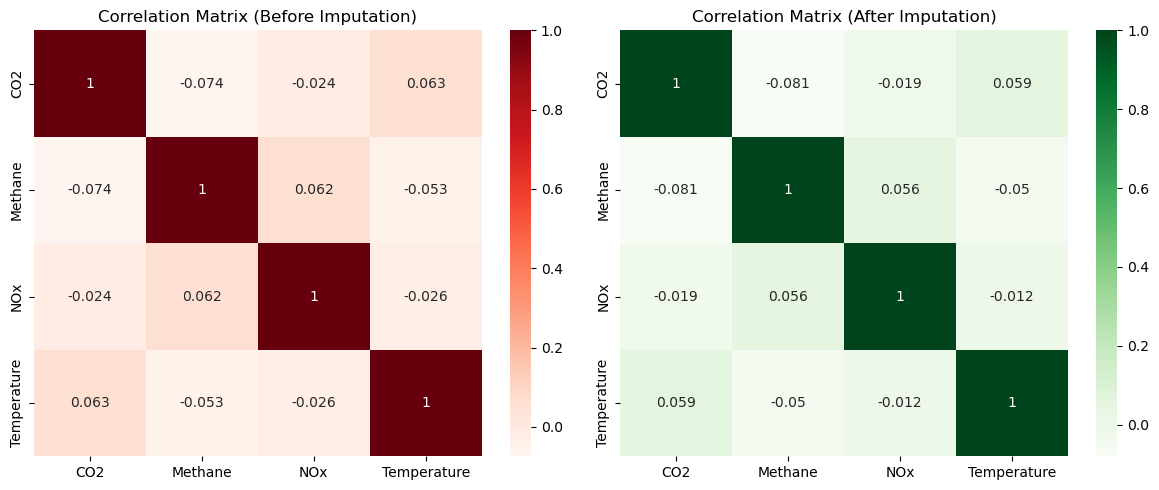

In [33]:
import seaborn as sns

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(data_missing.corr(), annot=True, cmap='Reds')
plt.title("Correlation Matrix (Before Imputation)")

plt.subplot(1, 2, 2)
sns.heatmap(data_imputed.corr(), annot=True, cmap='Greens')
plt.title("Correlation Matrix (After Imputation)")

plt.tight_layout()
plt.show()


The correlation matrices before and after imputation are very close, showing that the relationships between the variables have been well preserved. This similarity confirms that the imputation method effectively filled in missing values without significantly altering the original data structure or the dependencies among the features.